In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.0.0-alpha0
sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.2
pandas 0.24.2
sklearn 0.20.3
tensorflow 2.0.0-alpha0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.5))
# AlphaDropout: 1. 均值和方差不变 2. 归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [6]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 17s 318us/sample - loss: 1.2276 - accuracy: 0.5770 - val_loss: 0.7827 - val_accuracy: 0.7920
Epoch 2/10
55000/55000 [==============================] - 16s 293us/sample - loss: 0.7294 - accuracy: 0.7639 - val_loss: 0.7274 - val_accuracy: 0.8336
Epoch 3/10
55000/55000 [==============================] - 15s 274us/sample - loss: 0.6002 - accuracy: 0.8067 - val_loss: 0.7089 - val_accuracy: 0.8452
Epoch 4/10
55000/55000 [==============================] - 15s 274us/sample - loss: 0.5331 - accuracy: 0.8278 - val_loss: 0.6283 - val_accuracy: 0.8530
Epoch 5/10
55000/55000 [==============================] - 15s 278us/sample - loss: 0.4917 - accuracy: 0.8402 - val_loss: 0.6323 - val_accuracy: 0.8550
Epoch 6/10
55000/55000 [==============================] - 15s 275us/sample - loss: 0.4648 - accuracy: 0.8471 - val_loss: 0.5987 - val_accuracy: 0.8658
Epoch 7/10
55000/55000 [=====================

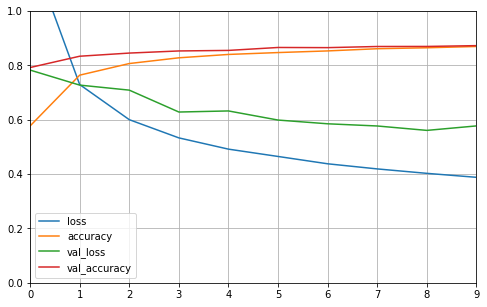

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    selu缓解梯度消失

In [8]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 2s 159us/sample - loss: 0.6630 - accuracy: 0.8531


[0.6629706964790821, 0.8531]